<a href="https://colab.research.google.com/github/duanasq/learning-ds-public/blob/main/dl-fundamentals/residual_nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise: Understand Residual Nets 

Generate a training set of periodic functions with different periods (e.g. sin(x), sin(2x) etc). Evaluate them on a regular grid (size n=1024). Input these into a FC neural network, and use the frequency as a label. Compare your results with a deep residual network.

In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torchsummary import summary
from sklearn.model_selection import train_test_split
import matplotlib.animation as animation

## Step 1. Generate training and test data

The first challenge was understanding what a single sample of data would look like. We decided a single sample would be a vector of length 1024 where each component was `sin(x)` or `sin(kx)` where `x` is between `-10*pi` and `10*pi` and k is the frequency which we will vary. Well, it's not technically the frequency as per the physics definition. To keep things simple, it is the parameter we want the neural net to learn.

TODO: How could we add noise to the data?

In [11]:
def dataset_generate(num_samples):
  size_image = 1024
  # we distinguish btw X and Y vs x and y: 
  # X is the collection of our data samples
  # Y is the collection of the corresponding labels
  # x is used to generate our sin values
  # y is the generated sin value
  X = []
  Y = []
  for i in range(num_samples):
    k = np.random.uniform(low = 0.1, high = 11) # this is the parameter we want to vary and get the NN to learn
    a = 1 #np.random.randn() # this is the amplitude - we will fix this now, but we could vary this in future too
    b = 0 #np.random.randn() # this is the y intercept. ditto
    x = np.linspace(-10*np.pi, 10 * np.pi, size_image) 
    y = a*np.sin(k*x) + b
    X.append(y)
    Y.append(k)
  return np.array(X), np.array(Y)


In [12]:
train_X, train_Y = dataset_generate(1000)
test_X, test_Y = dataset_generate(100)

(1000, 1024)
[-0.38264364 -0.42130321 -0.4592117  ...  0.4592117   0.42130321
  0.38264364]
0.6875013708986321


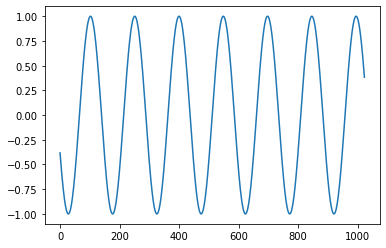

[-0.66615022 -0.50645472 -0.32697557 ...  0.32697557  0.50645472
  0.66615022]
3.223205904293191


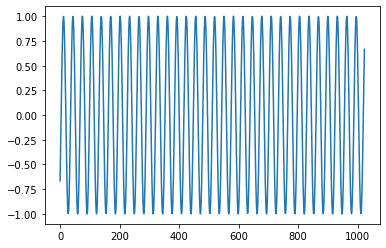

[-0.66158991 -0.79068266 -0.8916195  ...  0.8916195   0.79068266
  0.66158991]
3.076988199074469


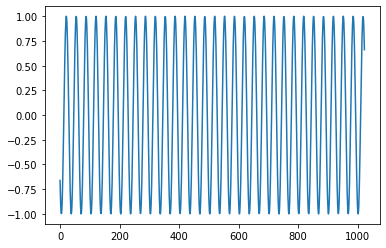

[-0.61641294 -0.07319067  0.49485394 ... -0.49485394  0.07319067
  0.61641294]
9.621141477270378


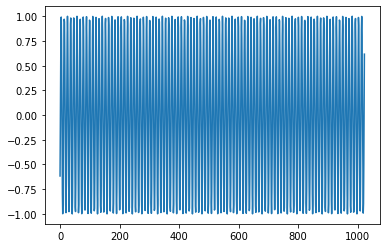

[ 0.80947721  0.8295317   0.84856969 ... -0.84856969 -0.8295317
 -0.80947721]
0.5699750639483169


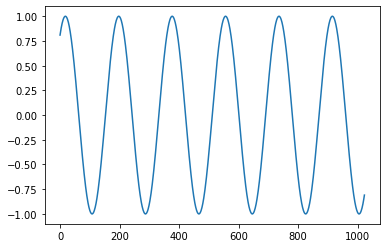

In [15]:
print(train_X.shape)

def display_samples(data, labels, num):
  for i in range(num):
    print(data[i])
    print(labels[i])
    plt.plot(data[i])
    plt.show()

display_samples(train_X, train_Y, 5)

## Step 2. Define a model

We will start with a model with a number of fully-connected layers.

In [ ]:
def make_model():
  return nn.Sequential(nn.Linear(1024, 1024), nn.Tanh(), nn.Linear(1024, 1024), nn.Tanh(), nn.Linear(1024, 1), nn.Sigmoid())

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return train_loss / len(dataloader.dataset)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader) 
    model.eval()
    test_loss, correct, relative_error = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            relative_error_temp = abs(y - pred) / abs(y)
            relative_error +=  relative_error_temp.type(torch.float).sum().item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    relative_error /= size
    return test_loss
   # relative_error_final = relative_error.type(torch.float).sum().item()/ size
    #correct /= size

In [ ]:
def plot_model(model):
  arr = np.linspace(0, 1, num=500)[:, np.newaxis]
  x = torch.Tensor(arr)
  y = model(x).detach()
 # poly = np.poly1d([1, -28, 322, -1960, 6769, -13132, 13068, -540])
  y_real =  3* x[:,0] - 7#poly(arr)#5*x[:,0]**5 + 4*x[:,0]**4 + 3*x[:,0]**3 + 2*x[:,0]**2 + x[:,0] + 42 #3 * x[:,0] - 7
  #print('plotmodel')
  #print(x,y)
  df = pd.DataFrame(data = {"x": x[:, 0], "y": y[:, 0], "y_real": y_real}).melt(id_vars='x', value_vars=['y', 'y_real'])
  #print(df.head())
  sns.scatterplot(data = df, x='x', y='value', hue='variable')
  plt.show()


In [ ]:

def run_model(model):
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
  print(model)

  epochs = 300
  for t in range(epochs):
      #print(f"Epoch {t+1}\n-------------------------------")
      train(train_dataloader, model, loss_fn, optimizer)
      test(test_dataloader, model, loss_fn)
  print("Done!")
  plot_model(model)

In [ ]:
train_tensor_x = torch.Tensor(train_X)
train_tensor_y = torch.Tensor(train_Y)
test_tensor_x = torch.Tensor(test_X)
test_tensor_y = torch.Tensor(test_Y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  """Entry point for launching an IPython kernel.


In [ ]:
train_dataset = TensorDataset(train_tensor_x, train_tensor_y)
train_dataloader = DataLoader(train_dataset, batch_size=10)
test_dataset = TensorDataset(test_tensor_x, test_tensor_y)
test_dataloader = DataLoader(test_dataset, batch_size=10)
print(len(test_dataloader))
print(len(test_dataloader.dataset))

10
100


In [ ]:
import numpy as np

from matplotlib import pyplot as plt

noise_scale = 0.1

def dataset_generate(num_dataset):
  size_image = 32 * 32
  X = []
  Y = []
  for i in range(num_dataset):
    freq = np.random.uniform(low = 0.1, high = 11)
    a = 1 #np.random.randn()
    b = 0 #np.random.randn()
    x = np.linspace(-10*np.pi, 10 * np.pi, size_image) # + np.random.randn(size_image, 1)
    y = a*np.sin(freq *x) + b

    y += noise_scale*(np.random.random(1024) - 0.5)

    X.append(y)
    Y.append(freq)
    print(x)
    plt.plot(x,y)
    plt.show()

[-31.41592654 -31.35450732 -31.29308811 ...  31.29308811  31.35450732
  31.41592654]


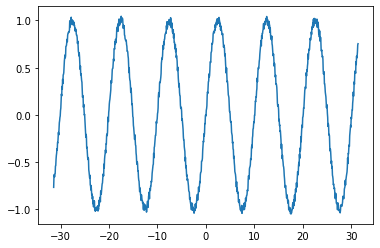

[-31.41592654 -31.35450732 -31.29308811 ...  31.29308811  31.35450732
  31.41592654]


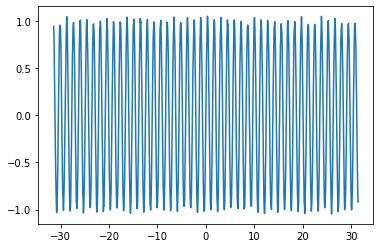

[-31.41592654 -31.35450732 -31.29308811 ...  31.29308811  31.35450732
  31.41592654]


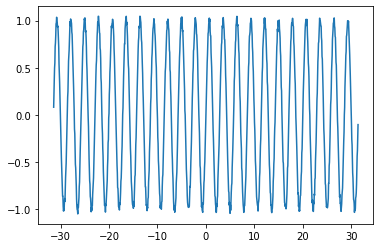

In [ ]:
dataset_generate(3)

In [ ]:
def dataset_generate2(num_dataset):
  noise_scale = 0.1
  feature_size = 1024
  a = 1
  b = 0
  Y = np.random.uniform(low = 0.1, high = 11, size=(num_dataset, 1))
  temp = np.linspace(-10*np.pi, 10 * np.pi, feature_size).reshape(1, feature_size)
  X = np.sin(Y * x) + noise_scale * (np.random.random((num_dataset, feature_size)) - 0.5)
  return X, Y

In [ ]:
Y = np.random.uniform(low = 0.1, high = 11, size=(1024, 1))

In [ ]:
x = np.linspace(-10*np.pi, 10 * np.pi, 1024).reshape(1,1024)

In [ ]:
A = np.sin(Y * x) + 0.1*(np.random.random((1000,1024)) - 0.5)
print(A.shape)


(1000, 1024)


In [ ]:
X,Y = dataset_generate2(5)
print(X.shape)
print(Y.shape)

(5, 1024)
(5, 1)
